데이터 로드, 분할 및 전처리

In [369]:
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from kerastuner.tuners import Hyperband
import pickle
from keras.models import Sequential
from keras.layers import Dense, Dropout,LSTM,LeakyReLU
from sklearn.metrics import mean_squared_error
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import kerastuner as kt
import numpy as np
# 데이터 로드
with open('data.pkl', 'rb') as f:
    X = pickle.load(f)
with open('graph.pkl', 'rb') as f:
    Y = pickle.load(f)

# 데이터 분할
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42)   

X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
# print(Y_test.shape)


(7227, 4)
(7227, 201)
(3098, 4)


스케일러 인스턴스 생성, 적용

In [370]:
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
Y_train_scaled = scaler_Y.fit_transform(Y_train) 
X_test_scaled = scaler_X.transform(X_test)
Y_test_scaled = scaler_Y.transform(Y_test)
time_steps = X_train.shape[1]  # We take the number of features as time steps for this example
features = 1  # We assume each feature is treated as a separate time step

# Reshape X_train and X_test to be [samples, time_steps, features]
# X_train_reshaped = X_train.reshape((X_train_scaled.shape[0], time_steps, features))
# X_test_reshaped = X_test.reshape((X_test_scaled.shape[0], time_steps, features))

# # Now, let's print out the new shapes:
# print("New X_train shape for LSTM: ", X_train_reshaped.shape)
# print("New X_test shape for LSTM: ", X_test_reshaped.shape)


In [371]:

def r_squared(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return (1 - ss_res/(ss_tot + tf.keras.backend.epsilon()))

모델 구축

In [372]:
def build_model(hp):

    model = Sequential([
    
    Dense(256, activation='relu', input_dim=4),  # 입력층, 4개의 입력 노드와 128개의 노드를 가진 은닉층 
    Dense(256),  # 입력층
    LeakyReLU(alpha=0.01), 
    Dense(256, ),  # 입력층
    LeakyReLU(alpha=0.01), 
    Dense(512, activation='relu'),  # 은닉층
    Dropout(hp.Float('dropout', min_value=0, max_value=0.5, step=0.1)),  # 과적합 방지를 위한 드롭아웃 층  2번정도
    Dense(256),  # 입력층
    LeakyReLU(alpha=0.01), 
    Dense(256),  # 입력층
    LeakyReLU(alpha=0.01), 
    Dense(256),  # 입력층
    Dropout(hp.Float('dropout', min_value=0, max_value=0.5, step=0.1)),  # 과적합 방지를 위한 드롭아웃 층
    LeakyReLU(alpha=0.01),
    Dense(256),  # 입력층
    LeakyReLU(alpha=0.01),
    Dense(201, activation='linear')  # 출력층, 201개의 출력 노드
])
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=[r_squared]) #rmse
    return model


하이퍼파라미터 튜닝

In [373]:

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
tuner = Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=500,
    directory='my_dir',
    project_name='intro_to_kt'
)
tuner.search(X_train_scaled, Y_train_scaled, epochs=200 ,validation_split=0.1, callbacks=[early_stopping_callback])

# 최적의 하이퍼파라미터 찾기
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units_input')}, the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Reloading Tuner from my_dir/intro_to_kt/tuner0.json

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 384, the optimal learning rate for the optimizer
is 0.01.



모델 구조 출력 및 학습

In [374]:
model = tuner.hypermodel.build(best_hps)
model.summary()
history = model.fit(X_train_scaled, Y_train_scaled, epochs=200, batch_size=50,validation_split=0.1, verbose=1)  
print(history.history.keys())

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_355 (Dense)           (None, 256)               1280      
                                                                 
 dense_356 (Dense)           (None, 256)               65792     
                                                                 
 leaky_re_lu_66 (LeakyReLU)  (None, 256)               0         
                                                                 
 dense_357 (Dense)           (None, 256)               65792     
                                                                 
 leaky_re_lu_67 (LeakyReLU)  (None, 256)               0         
                                                                 
 dense_358 (Dense)           (None, 512)               131584    
                                                                 
 dropout_31 (Dropout)        (None, 512)             

훈련 및 검증 손실 그래프

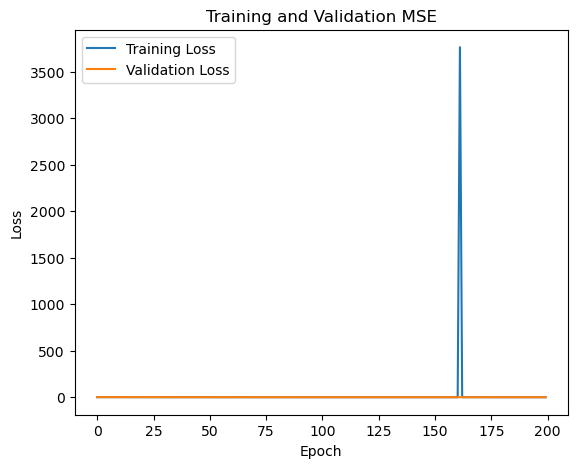

In [375]:
plt.figure(figsize=(14, 5))


plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

예측수행 및 시각화

226/226 [==============================] - 1s 5ms/step


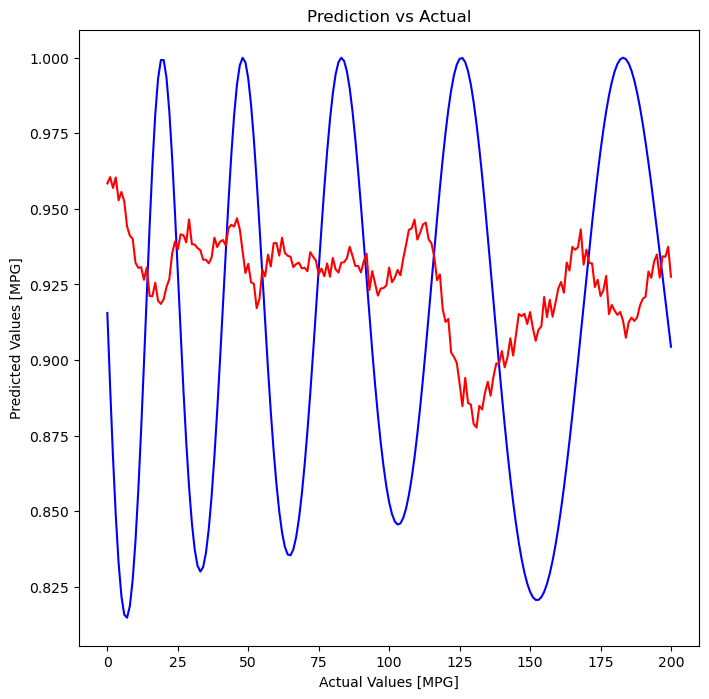

In [382]:
Y_pred_scaled= model.predict(X_test_scaled)
# 예측 결과를 원래 스케일로 되돌리기
Y_pred = scaler_Y.inverse_transform(Y_pred_scaled)

Y_pred2_scaled= model.predict(X_train_scaled)
# 예측 결과를 원래 스케일로 되돌리기
Y_pred2 = scaler_Y.inverse_transform(Y_pred2_scaled)

plt.figure(figsize=(8, 8))
plt.title('Prediction vs Actual')
r = np.random.randint(0, 201)
plt.plot(Y_test[r,:],color='blue' )
plt.plot(Y_pred[r,:],color='red' )
#plt.plot(Y_train[r,:],color='black' )
#plt.plot(Y_pred2[r,:],color='yellow' )
plt.xlabel('Actual Values [MPG]')
plt.ylabel('Predicted Values [MPG]')
plt.show()


In [377]:
test_loss, test_r_squared = model.evaluate(X_test, Y_test)

# 평가 결과 출력
print(f'Test Loss: {test_loss}')
print(f'Test R-Squared: {test_r_squared}')

97/97 [==============================] - 1s 5ms/step - loss: 247458.2344 - r_squared: -6312974.0000
Test Loss: 247458.234375
Test R-Squared: -6312974.0


In [378]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(n_estimators=100, contamination='auto', random_state=42)

# 학습 데이터셋에 모델 학습
clf.fit(X_train)

# 학습 데이터셋에 대한 이상치 예측
# 이 때, 반환값 -1은 이상치, 1은 정상 데이터를 의미합니다.
y_pred_train = clf.predict(X_train)

# 이상치의 개수 계산
anomalies_train = np.sum(y_pred_train == -1)

print(f"Number of anomalies in the training dataset: {anomalies_train}")
total_train_samples = X_train.shape[0]
print(f"Total number of training samples: {total_train_samples}")

# 테스트 데이터셋에 대해 이상치 예측
y_pred_test = clf.predict(X_test)

# 이상치의 개수 계산
# y_pred_test에서 -1은 이상치를 의미하므로, -1의 개수를 세어 이상치의 총 개수를 파악
anomalies_test = np.sum(y_pred_test == -1)

print(f"Number of anomalies in the test dataset: {anomalies_test}")

total_test_samples = X_test.shape[0]
print(f"Total number of training samples: {total_test_samples}")

Number of anomalies in the training dataset: 4368
Total number of training samples: 7227
Number of anomalies in the test dataset: 1905
Total number of training samples: 3098


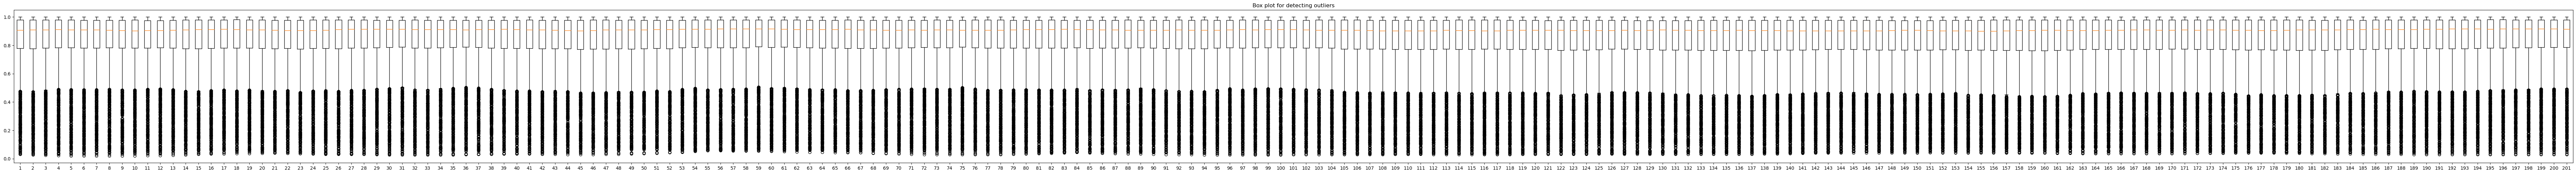

In [379]:
plt.figure(figsize=(100, 6))
plt.boxplot(Y_test)
plt.title('Box plot for detecting outliers')
plt.show()